# Trabalho A1 - Análise de Séries Temporais

## Instruções do Trabalho

Utilize o conjunto de dados `data.csv` disponibilizado no e-class. O arquivo contém as variáveis `week` e `volume`. Seu objetivo é modelar a variável `volume` utilizando os conceitos aprendidos em sala de aula.

**Linguagem de Programação:** Você pode utilizar Python ou R como linguagem de programação.

## Requisitos do Trabalho

Seu trabalho deve conter:

* **Discussão sobre métricas e métodos de avaliação**

* **Discussão sobre a necessidade de transformação de variáveis**

* **Discussão sobre a necessidade de decomposição entre tendência e sazonalidade**

* **Análises de resíduos e ajuste dos modelos**

* **Modelos baselines**

* **Modelos de regressão linear múltipla** utilizando co-variáveis criadas baseadas nas variáveis `week` e `volume`

## Entrega

Sua entrega deve conter:
- Link para um repositório no GitHub contendo o código
- Relatório de no máximo 5 páginas contendo um resumo executivo das suas análises


## Contexto

Ao longo do curso será disponibilizado mais variáveis para melhorar os resultados obtidos na A1.

## Dados

In [6]:
prison <- readr::read_csv("data.csv", show_col_types = FALSE)

In [9]:
head(prison)

week,volume
<date>,<dbl>
2022-10-31,0.33
2022-11-07,0.47
2022-11-14,0.32
2022-11-21,1.69
2022-11-28,1.23
2022-12-05,0.77


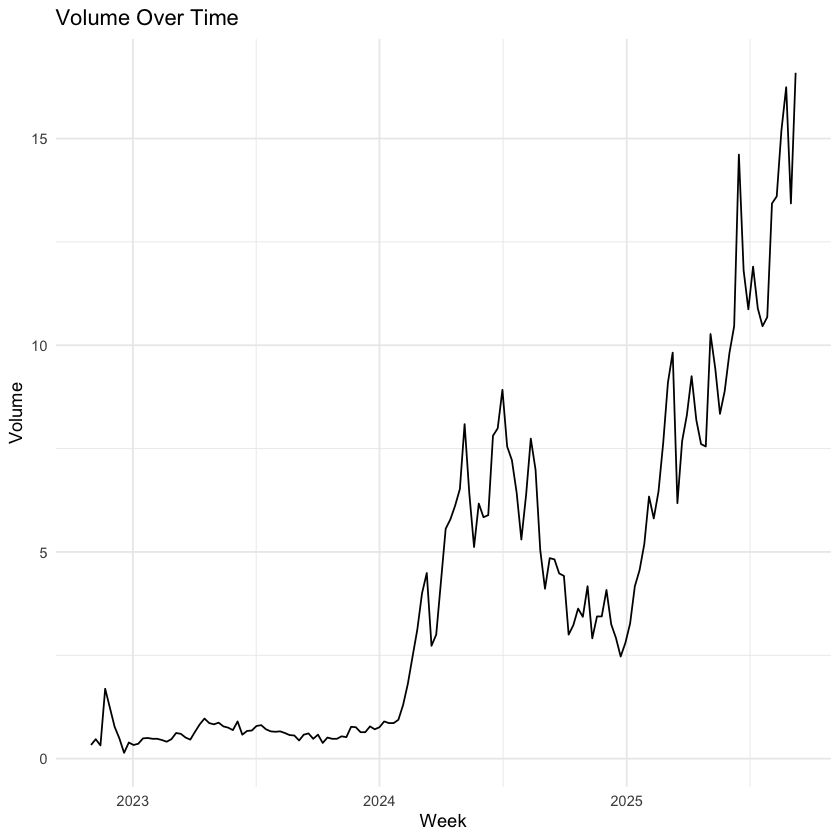

In [8]:
library(ggplot2)

ggplot(prison, aes(x = as.Date(week), y = volume)) +
  geom_line() +
  labs(x = "Week", y = "Volume", title = "Volume Over Time") +
  theme_minimal()